# Solving Problems by Searching

In [2]:
# import libraries
from search import * 
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# hide matplotlib warnings 
import warnings 
warnings.filterwarnings("ignore")

import timeit

# Contents
* Overview
* Problem
* Node
* Simple Problem Solving Agent
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Best First Search
* Uniform Cost Search
* Greedy Best First Search
* A* Search
* Hill Climbing
* Simulated Annealing
* Genetic Algorithm
* AND-OR Graph Search
* Online DFS Agent
* LRTA* Agent


# Overview

Here, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining problems and their solutions. We will look at several general-purpose search algorithms.

Search algorithms can be classified into two types:

* Uninformed search algorithms: Search algorithms which explore the search space without having any information about the problem other than its definition.
    * Examples:
        1. Breadth First Search
        2. Depth First Search
        3. Depth Limited Search
        4. Iterative Deepening Search
        5. Informed search algorithms: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
    * Examples:
        1. Best First Search
        2. Uniform Cost Search
        3. A* Search
        4. Recursive Best First Search

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in notebook.py.

In [60]:
%matplotlib inline 
import networkx as nx 
import matplotlib.pyplot as plt 
from matplotlib import lines 
from ipywidgets import interact 
import ipywidgets as widgets 
from IPython.display import display 
import time

In [17]:
# see definition of problem 
psource(Problem)

The Problem class has 6 methods: 

* init - constructor 
* actions - returns all possible actions an agent can execute in a given state 
* result - returns the resulting state if action action is taken in state state. This only deals with deterministic outcomes, so we know for sure what every action in a state would result to. 
* goal_test - return a boolean for a given state - True is goal state, false ow
* path_Cost : retuen the cost of the path that arrives at state2 as a result of taking action from state1, assuming total cost of c to get up to state1
* value - acts as extra information in problems where we try to optimize a value when we cannot do a goal test 

In [18]:
# see how Node is defined 
psource(Node)

The Node class has nine methods: 

* init : constructor. Creates a node, parent represents the node that this is a successor of and action is the action required to get from the parent node to this node. path_cost is the cost to reach the current node from the parent node. 
* expand: lists all the neighboring (reachable in 1 step) nodes of the current node
* child_node: given an action, returns the immediate neighbor that can be reached with that action 
* solution: returns the sequence of actions required to reach this node from the root node 
* path: returns a list of all the nodes that lie in the path from the root to this node 

The remaining methods override standard python functionality for representing an object as a string, the less than operator, the equal to operator and the hash function 

* __repr__ : returns that state of the node 
* __lt__ : given a node, returns true if the current state is less than another node's state. False ow
* __eq__ : returns true if the state of the current node is equal to another node, false ow
* __hash__ : returns the hash of the state of the current node 



In [5]:
# definition of GraphProblem
psource(GraphProblem)

The GraphProblem class has 6 methods. 

* init : a constructor. takes a goal node, initial node, and a graph 
* actions : returns a list of actions available given a state. These are its neighbors
* result : returns the result of going to a neighbor 
* path_cost : returns the cost of the path of nodes explored from root to the current node 
* h : returns the straight line distance from a node's state to its goal 


In [6]:
# look at map of Romania

romania_map = UndirectedGraph(dict(
    Arad = dict(Zerind = 75, Sibiu = 140, Timisoara = 118),
    Bucharest = dict(Urziceni = 85, Pitesti = 101, Giurgiu = 90, Fagaras = 211),
    Craiova = dict(Drobeta = 120, Rimnicu = 146, Pitesti = 138),
    Drobeta = dict(Mehadia = 75),
    Eforie = dict(Hirsova = 86),
    Fagaras = dict(Sibiu = 99),
    Hirsova = dict(Urziceni = 98),
    Iasi = dict(Vaslui = 92, Neamt = 87),
    Lugoj = dict(Timisoara = 111, Mehadia = 70),
    Oradea = dict(Zerind = 71, Sibiu = 151),
    Pitesti = dict(Rimnicu = 97),
    Rimnicu = dict(Sibiu = 80),
    Urziceni = dict(Vaslui = 142)))

romania_map.locations = dict(
    Arad = (91, 492), Bucharest = (400, 327), Craiova = (253, 288),
    Drobeta = (165, 299), Eforie = (562, 293), Fagaras = (305, 449),
    Giurgiu = (375, 270), Hirsova = (534, 350), Iasi = (473, 506),
    Lugoj = (165, 379), Mehadia = (168, 339), Neamt = (406, 537),
    Oradea = (131, 571), Pitesti = (320, 368), Rimnicu = (233, 410),
    Sibiu = (207, 457), Timisoara = (94, 410), Urziceni = (456, 350),
    Vaslui = (509, 444), Zerind = (108, 531))

It is pretty straightforward to understand this romania_map. The first node Arad has three neighbours named Zerind, Sibiu, Timisoara. Each of these nodes are 75, 140, 118 units apart from Arad respectively. And the same goes with other nodes.

And romania_map.locations contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in romania_map) between two cities in algorithms like A*-search and Recursive Best First Search.

Define a problem: Now it's time to define our problem. We will define it by passing initial, goal, graph to GraphProblem. So, our problem is to find the goal state starting from the given initial state on the provided graph.

In [7]:
# starting from Arad, try to find Bucharest
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)


In [8]:
# have a look at romania_locations 
romania_locations = romania_map.locations 
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Now we can initialize an empty graph, add nodes, place the nodes in their locations and add edges to the graph 

In [9]:
# node colors, positions, and labels 
node_colors = {node: 'white' for node in romania_map.locations.keys()} 
node_positions = romania_map.locations
node_label_pos = {k:[v[0], v[1]-10] for k, v in romania_map.locations.items()}
edge_weights = {(k, k2):v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

# define graph 
romania_graph_data = {'graph_dict' : romania_map.graph_dict, 
                      'node_colors' : node_colors,
                      'node_positions' : node_positions, 
                      'node_label_positions' : node_label_pos, 
                      'edge_weights' : edge_weights}

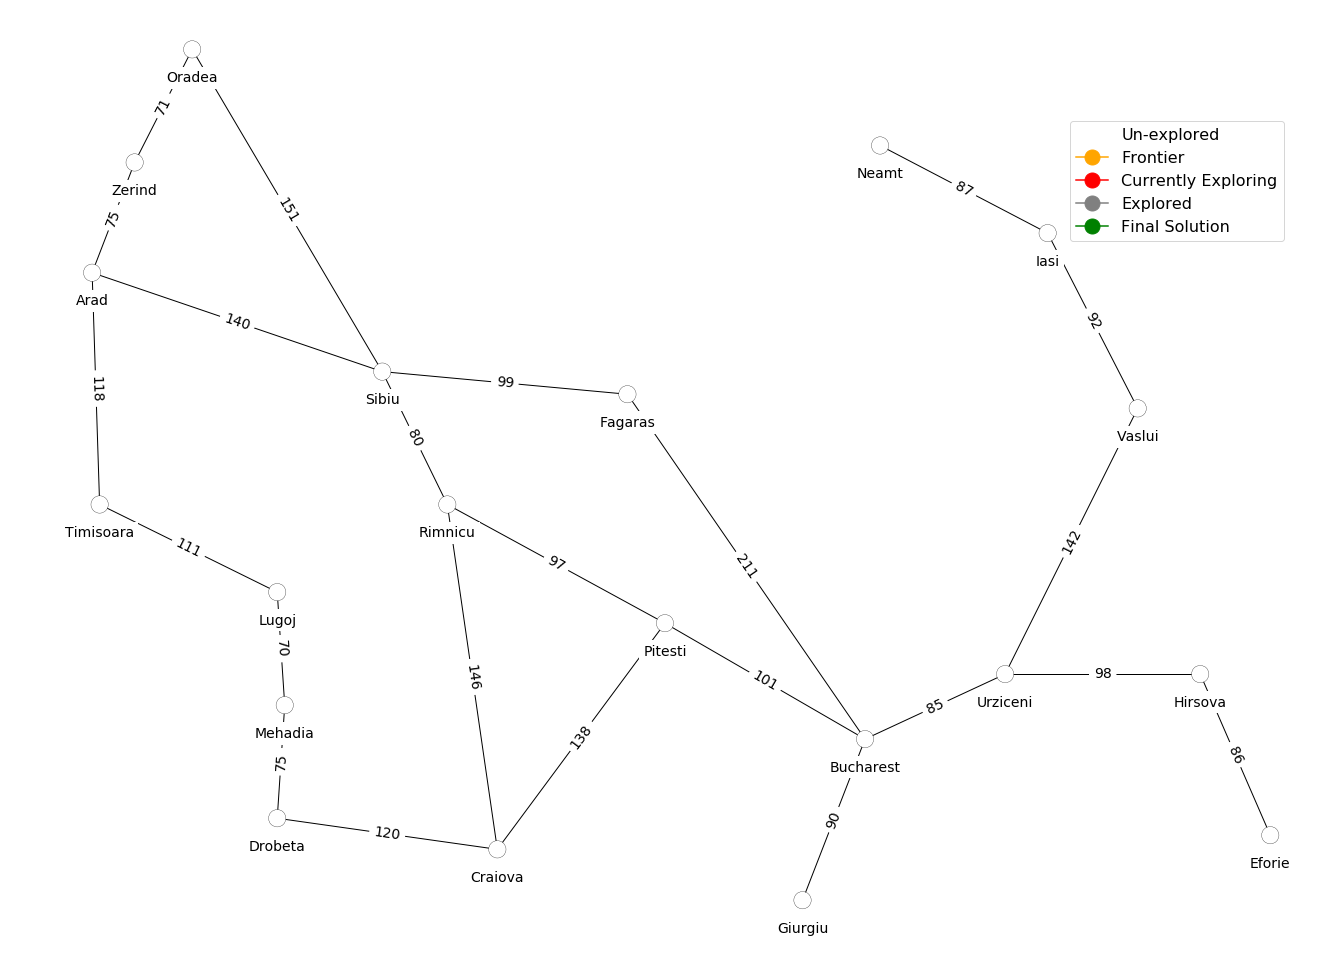

In [10]:
# Now that we have built our graph, lets display it! 
show_map(romania_graph_data)

# Simple Problem Solving Agent Program

In [11]:
# view class for simple problem solving agent program 
psource(SimpleProblemSolvingAgentProgram)

The SimpleProblemSolvingAgentProgram class has six methods: 

* __init__: constructor. It takes a keyword argument, initial_state which is None by default. This represents the state from which the agent starts. 
* __call__(self, percept): updates the state of the agent based on its percept using the update_state method. It then formulates a goal with the help of formulate_goal method and problem using the formulate_problem method. Then it returns a sequence of actions to solve it  using the search method. 
* update_state(self, percept): updates the state based on the percept 
* formulate_goal(self, state): given a state of the agent, formulate a goal 
* formulate_problem(self, state, goal): given a state and goal, formulate a problem 
* search(self, problem): search a sequence of actions to solve a problem 

We will now define a simple problem solving agent program. 

![](https://github.com/aimacode/aima-python/raw/fb9b85a7b87091484e4b7e96aaec972598a1696d/images/simple_problem_solving_agent.jpg)

In [12]:
class VacuumAgent(SimpleProblemSolvingAgentProgram):
    def update_state(self, state, percept): 
        return percept 
    
    def formulate_goal(self, state): 
        goal = [state7, state8]
        return goal
    
    def formulate_problem(self, state, goal): 
        problem = state 
        return problem 
    
    def search(self, problem): 
        if problem == state1: 
            seq = ["Suck", "Right", "Suck"]
        elif problem == state2: 
            seq = ["Suck", "Left", "Suck"]
        elif problem == state3: 
            seq = ["Right", "Suck"]
        elif problem == state4: 
            seq = ["Suck"]
        elif problem == state5: 
            seq = ["Suck"]
        elif problem == state6: 
            seq = ["Left", "Suck"]
        return seq

In [13]:
# create objects of the above class 
state1 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state2 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state3 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state4 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state5 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state6 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state7 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]
state8 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]

a = VacuumAgent(state1)

print(a(state6)) 
print(a(state1))
print(a(state3))

Left
Suck
Right


# Search Algorithm Visualization

In this section, there are visualizations of the following search algorithms: 

1. Breadth First Tree Search 
2. Depth First Tree Search 
3. Breadth First Search 
4. Depth First Graph Search 
5. Best First Graph Search 
6. Uniform Cost Search 
7. Depth Limited Search 
8. Iterative Deepening Search 
9. Greedy Best First Search
10. A* Search
11. Recursive Best First Search

### Breadth First Tree Search

In [14]:
# Breadth First Tree Search 
def breadth_first_tree_search_vis(problem):
    '''Search through the successors of a problem to find a goal'''
    
    # declarations 
    iterations = 0
    all_node_colors = []
    node_colors = {k: 'white' for k in problem.graph.nodes()}
    
    # add first node to the queue 
    frontier = deque([Node(problem.initial)])
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    # loop through frontier nodes 
    while frontier: 
        # pop first node 
        node = frontier.popleft() 
        
        # modify current searching node to red 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify the goal node to green once goal is reached 
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        # else expand frontier 
        frontier.extend(node.expand(problem))
        
        for n in node.expand(problem): 
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))
        
        # color explored nodes gray 
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    return None

In [15]:
def breadth_first_tree_search(problem): 
    iterations, all_node_colors, node = breadth_first_tree_search_vis(problem)
    return(iterations, all_node_colors, node)

In [16]:
# node colors list
all_node_colors = []

# define graph to explore
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

# call 3 different searches on graph
iter1, iter2, iter3 = breadth_first_tree_search(romania_problem)

# display 
display_visual(romania_graph_data, user_input = False, 
               algorithm = breadth_first_tree_search, problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Depth First Tree Search

In [17]:
def depth_first_tree_search_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the stack
    frontier = [Node(problem.initial)]
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

In [18]:
def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    iterations, all_node_colors, node = depth_first_tree_search_vis(problem)
    return(iterations, all_node_colors, node)

In [19]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
               algorithm = depth_first_tree_search, 
               problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Breadth First Graph Search 

In [20]:
def breadth_first_graph_search(problem):
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    # add first node
    node = Node(problem.initial)
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    # goal found? 
    if problem.goal_test(node.state): 
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    # else expand frontier 
    frontier = deque([node])
    
    # modify color of frontier nodes 
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set() 
    
    while frontier: 
        node = frontier.popleft() 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors)) 
        
        explored.add(node.state)
        
        for child in node.expand(problem): 
            if child.state not in explored and child not in frontier: 
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)
                
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
        
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    return None

In [21]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = breadth_first_graph_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Depth First Graph Search 

In [22]:
def depth_first_graph_search_vis(problem): 
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [(Node(problem.initial))]
    explored = set() 
    
    # make frontier nodes orange 
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier: 
        # pop first node 
        node = frontier.pop() 
        
        # make currently searching node red 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reached 
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                       if child.state not in explored
                       and child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange 
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            
    return None

In [23]:
def depth_first_graph_search(problem): 
    iterations, all_node_colors, node = depth_first_graph_search_vis(problem)
    return(iterations, all_node_colors, node)

In [24]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = depth_first_graph_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Best First Search 

In [25]:
def best_first_graph_search_vis(problem, f): 
    '''
    Searches nodes with the lowest f scores first. 
    Specify the function f(node) that we wish to minimize
    '''
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    # dynamic programming 
    f = memoize(f, 'f')
    
    # initialize
    node = Node(problem.initial)
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    # if goal found
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    
    while frontier: 
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem): 
            if child.state not in explored and child not in frontier: 
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier: 
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

### Uniform Cost Search 

In [26]:
def uniform_cost_graph_search(problem): 
    # UCGS uses best first search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search_vis(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)

In [27]:
all_node_colors = [] 
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = uniform_cost_graph_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Depth Limited Search 

In [28]:
def depth_limited_graph_search_vis(problem, limit = -1): 
    '''
    Perform depth first search on a graph. 
    If limit >= 0, that is the maximum depth of the search
    '''
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [Node(problem.initial)]
    explored = set() 
    
    cutoff_occurred = False 
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier: 
        node = frontier.pop() 
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        elif limit >= 0: 
            cutoff_occurred = True
            limit += 1
            all_node_color.pop() 
            iterations -= 1
            node_colors[node.state] = "gray"
            
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                       if child.state not in explored 
                       and child not in frontier)
        
        for n in frontier: 
            limit -= 1
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    
    return 'cutoff' if cutoff_occurred else None 

In [29]:
def depth_limited_graph_search(problem): 
    iterations, all_node_colors, node = depth_limited_graph_search_vis(problem)
    return(iterations, all_node_colors, node)

In [30]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = depth_limited_graph_search,
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Iterative Deepening Search

In [31]:
def iterative_deepening_search(problem): 
    for depth in range(sys.maxsize):
        iterations, all_node_colors, node = depth_limited_graph_search(problem)
        if iterations: 
            return(iterations, all_node_colors, node)

In [32]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = iterative_deepening_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Greedy Best First Search 

In [33]:
def greedy_best_first_search(problem, h = None): 
    '''
    best first graph search with f(n) = h(n), a heuristic function
    h(n) must be specified when best_first_search is called or in problem subclass
    '''
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_vis(problem, lambda n: h(n))
    return(iterations, all_node_colors, node)

In [34]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = greedy_best_first_search, 
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### A* Search 

In [35]:
def astar_graph_search(problem, h = None): 
    '''
    a* is a best-first graph search with f(n) = g(n) + h(n)
    '''
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_vis(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

In [36]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = astar_graph_search,
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### Recursive Best First Search 

In [37]:
def recursive_best_first_search_vis(problem, h = None): 
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    h = memoize(h or problem.h, 'h')
    
    def RBFS(problem, node, flimit): 
        nonlocal iterations 
        def color_city_and_update_map(node, color): 
            node_colors[node.state] = color 
            nonlocal iterations 
            iterations += 1
            all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state): 
            color_city_and_update_map(node, 'green')
            return(iterations, all_node_colors, node), 0
        
        successors = node.expand(problem)
        
        if len(successors) == 0: 
            color_city_and_update_map(node, 'gray')
            return(iterations, all_node_colors, None), infinity
        
        for s in successors: 
            color_city_and_update_map(s, 'orange')
            s.f = max(s.path_cost + h(s), node.f)
        
        while True: 
            # order by lowest f value 
            successors.sort(key = lambda x: x.f)
            best = successors[0]
            if best.f > flimit: 
                color_city_and_update_map(node, 'gray')
                return(iterations, all_node_colors, None), best.f
            
            if len(successors) > 1: 
                alternative = successors[1].f
            else: 
                alternative = infinity 
            
            node_colors[node.state] = 'gray'
            node_colors[node.state] = 'red'
            iterations += 1
            all_node_colors.append(dict(node_colors))
            result, best.f = RBFS(problem, best, min(flimit, alternative))
            if result[2] is not None: 
                color_city_and_update_map(node, 'green')
                return result, best.f 
            else: 
                color_city_and_update_map(node, 'red')
    node = Node(problem.initial)
    node.f = h(node)
    
    node_colors[node.state] = 'red'
    iterations += 1
    all_node_colors.append(dict(node_colors))
    result, bestf = RBFS(problem, node, infinity)
    return result

In [38]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input = False, 
              algorithm = recursive_best_first_search_vis,
              problem = romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

In [39]:
all_node_colors = []
# display_visual(romania_graph_data, user_input=True, algorithm=breadth_first_tree_search)
algorithms = {  "Breadth First Tree Search": breadth_first_tree_search_vis,
                "Depth First Tree Search": depth_first_tree_search_vis,
                "Breadth First Search": breadth_first_graph_search,
                "Depth First Graph Search": depth_first_graph_search_vis ,
                "Best First Graph Search": best_first_graph_search_vis ,
                "Uniform Cost Search": uniform_cost_graph_search,
                "Depth Limited Search": depth_limited_graph_search_vis,
                "Iterative Deepening Search": iterative_deepening_search,
                "Greedy Best First Search": greedy_best_first_search,
                "A-star Search": astar_search,
                "Recursive Best First Search": recursive_best_first_search_vis}
display_visual(romania_graph_data, algorithm=algorithms, user_input=True)

Dropdown(description='Search algorithm: ', index=3, options=('A-star Search', 'Best First Graph Search', 'Brea…

Dropdown(description='Start city: ', options=('Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', …

Dropdown(description='Goal city: ', index=5, options=('Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fa…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

### Recursive Best First Search

Recursive best-first search is a simple recursive algorithm that improves upon heuristic search by reducing the memory requirement. RBFS uses only linear space and it attempts to mimic the operation of standard best-first search. Its structure is similar to recursive depth-first search but it doesn't continue indefinitely down the current path, the f_limit variable is used to keep track of the f-value of the best alternative path available from any ancestor of the current node. RBFS remembers the f-value of the best leaf in the forgotten subtree and can decide whether it is worth re-expanding the tree later. 
However, RBFS still suffers from excessive node regeneration. 
Let's have a look at the implementation.

In [40]:
# look at implementation 
psource(recursive_best_first_search)

In [41]:
# solving the romania problem 
recursive_best_first_search(romania_problem).solution()

['Sibiu', 'Rimnicu', 'Pitesti', 'Bucharest']

In [42]:
# solving the 8 puzzle problem 
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
assert puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0))
recursive_best_first_search(puzzle).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

### A* Heuristics 

Different heuristics provide different efficiency in solving A* problems which are generally defined by the number of explored nodes as well as the branching factor. With the classic 8 puzzle we can show the efficiency of different heuristics through the number of explored nodes.

In [43]:
# set goal state 
goal = [1, 2, 3, 4, 5, 6, 7, 8, 0]

#### Heuristics 

1. Manhattan Distance
2. Number of Misplaced Tiles 
3. Sqrt of Manhattan Distance 
4. Max Heuristic (max between manhattan distance and number of misplaced tiles)

In [16]:
def linear(node): 
    return sum([1 if node.state[i] != goal[i] else 0 for i in range(8)])

def manhattan(node): 
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = abs(index_goal[i][j] - index_state[i][j]) + mhd
    
    return mhd

def sqrt_manhattan(node):
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = (index_goal[i][j] - index_state[i][j])**2 + mhd
    
    return math.sqrt(mhd)

def max_heuristic(node):
    score1 = manhattan(node)
    score2 = linear(node)
    return max(score1, score2)

In [45]:
# solve puzzle 
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))

# checks whether the initialized configuration is solvable or not
puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0))

True

In [46]:
# default astar search returns number of misplaced tiles 
astar_search(puzzle).solution() 

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In [47]:
# linear heuristic 
astar_search(puzzle, linear).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In [48]:
# manhattan distance 
astar_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [49]:
# sqrt manhattan 
astar_search(puzzle, sqrt_manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [50]:
# max heuristic 
astar_search(puzzle, max_heuristic).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [51]:
# recursive best first search 
recursive_best_first_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'UP', 'DOWN', 'RIGHT']

The different heuristics returned the same answer, but they have different computation times 

In [52]:
# define test puzzles
puzzle_1 = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
puzzle_2 = EightPuzzle((1, 2, 3, 4, 5, 6, 0, 7, 8))
puzzle_3 = EightPuzzle((1, 2, 3, 4, 5, 7, 8, 6, 0))

In [53]:
# default 
%timeit astar_search(puzzle_1)
%timeit astar_search(puzzle_2)
%timeit astar_search(puzzle_3)


894 µs ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
135 µs ± 865 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
The slowest run took 7.07 times longer than the fastest. This could mean that an intermediate result is being cached.
12.5 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
# linear
%timeit astar_search(puzzle_1, linear)
%timeit astar_search(puzzle_2, linear)
%timeit astar_search(puzzle_3, linear)

907 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
143 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.03 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
# manhattan
%timeit astar_search(puzzle_1, manhattan)
%timeit astar_search(puzzle_2, manhattan)
%timeit astar_search(puzzle_3, manhattan)

1.57 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
201 µs ± 4.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.46 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
# sqrt manhattan
%timeit astar_search(puzzle_1, sqrt_manhattan)
%timeit astar_search(puzzle_2, sqrt_manhattan)
%timeit astar_search(puzzle_3, sqrt_manhattan)

4.58 ms ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
234 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
38.9 ms ± 962 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
# max heuristic 
%timeit astar_search(puzzle_1, max_heuristic)
%timeit astar_search(puzzle_2, max_heuristic)
%timeit astar_search(puzzle_3, max_heuristic)

1.82 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
240 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.14 ms ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
# recursive best first search 
%timeit recursive_best_first_search(puzzle_1, linear)
%timeit recursive_best_first_search(puzzle_2, linear)
%timeit recursive_best_first_search(puzzle_3, linear)

1.49 ms ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
101 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
358 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Hill Climbing 

Hill climbing is a heuristic search used for optimization problems. Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. This solution may be a global maxima or minima, but is often a local maxima or minima. These belong to a class of algorithms known as generate and test algorithms. 

It works as follows: 

- Evaluate the initial statee
- If it is equal to the goal state, then return 
- Find a neighboring state (one which is heuristically similar to the current state)
- Evaluate this state. If it is closer to the goal state than before, replace the initial state with this state and repeat these steps. 

In [121]:
psource(hill_climbing)

def hill_climbing(problem):
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            break
        current = neighbor
    return current.state

We will find an approximate solution to the traveling salesperson problem using this algorithm. 

In [84]:
class TSP_problem(Problem):

    """ subclass of Problem to define various functions """

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        """ total distance for the Traveling Salesman to be covered if in state2  """
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]
        cost += distances[state2[0]][state2[-1]]
        return cost

    def value(self, state):
        """ value of path cost given negative for the given state """
        return -1 * self.path_cost(None, None, None, state)


We will use the cities from the Romania map for this problem. 

In [85]:
distances = {}
all_cities = []

# populate hash table
for city in romania_map.locations.keys():
    distances[city] = {}
    all_cities.append(city)
    
all_cities.sort()
print(all_cities)

['Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', 'Giurgiu', 'Hirsova', 'Iasi', 'Lugoj', 'Mehadia', 'Neamt', 'Oradea', 'Pitesti', 'Rimnicu', 'Sibiu', 'Timisoara', 'Urziceni', 'Vaslui', 'Zerind']


In [86]:
import numpy as np
for name_1, coordinates_1 in romania_map.locations.items():
        for name_2, coordinates_2 in romania_map.locations.items():
            distances[name_1][name_2] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
            distances[name_2][name_1] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])


The way neighbors are currentl chosen isn't suitable for the traveling salesperson problem. We need a neighboring state that is similar in total path distance to the current state. We must change the function that finds neighbors

In [87]:
def hill_climbing(problem):
    
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    
    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """
        
        neighbors = []
        
        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state
            
        return neighbors

    # as this is a stochastic algorithm, we will set a cap on the number of iterations
    iterations = 10000
    
    current = Node(problem.initial)
    while iterations:
        neighbors = find_neighbors(current.state)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            current.state = neighbor.state
        iterations -= 1
        
    return current.state

In [88]:
# create an instance of the TSP_problem class
tsp = TSP_problem(all_cities)

In [113]:
# solve the traveling salesperson problem 
hill_climbing(tsp)

['Fagaras',
 'Iasi',
 'Bucharest',
 'Pitesti',
 'Arad',
 'Zerind',
 'Oradea',
 'Craiova',
 'Timisoara',
 'Rimnicu',
 'Urziceni',
 'Drobeta',
 'Eforie',
 'Sibiu',
 'Neamt',
 'Lugoj',
 'Hirsova',
 'Giurgiu',
 'Mehadia',
 'Vaslui']

### Simulated Annealing 

The intuition behind Hill Climbing was developed from the metaphor of climbing up the graph of a function to find its peak. There is a fundamental problem in the implementation of the algorithm however. To find the highest hill, we take one step at a time, always uphill, hoping to find the highest point, but if we are unlucky to start from the shoulder of the second-highest hill, there is no way we can find the highest one. The algorithm will always converge to the local optimum. Hill Climbing is also bad at dealing with functions that flatline in certain regions. If all neighboring states have the same value, we cannot find the global optimum using this algorithm.

Let's now look at an algorithm that can deal with these situations.
Simulated Annealing is quite similar to Hill Climbing, but instead of picking the best move every iteration, it picks a random move. If this random move brings us closer to the global optimum, it will be accepted, but if it doesn't, the algorithm may accept or reject the move based on a probability dictated by the temperature. When the temperature is high, the algorithm is more likely to accept a random move even if it is bad. At low temperatures, only good moves are accepted, with the occasional exception. This allows exploration of the state space and prevents the algorithm from getting stuck at the local optimum.

In [93]:
psource(simulated_annealing)

In [95]:
# The temperature is gradually decreased over the course of the iteration. This is done by a scheduling routine. The current implementation uses exponential decay of temperature, but we can use a different scheduling routine instead 
psource(exp_schedule)

Next we will define a peak-finding problem and try to solve it using simulated annealing. Let's define the grid and initial state first.

In [96]:
# set initial conditions 
initial = (0, 0)
grid = [[3, 7, 2, 8], [5, 2, 9, 1], [5, 3, 3, 1]] 

# dictionary for directions
directions4

# define problem with given parameters 
problem = PeakFindingProblem(initial, grid, directions4)

In [99]:
# run simulated_annealing 100 times and take the max value to find (hopefully) the global maxima
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

9

Let's find the peak of a two dimensional gaussian distribution. 

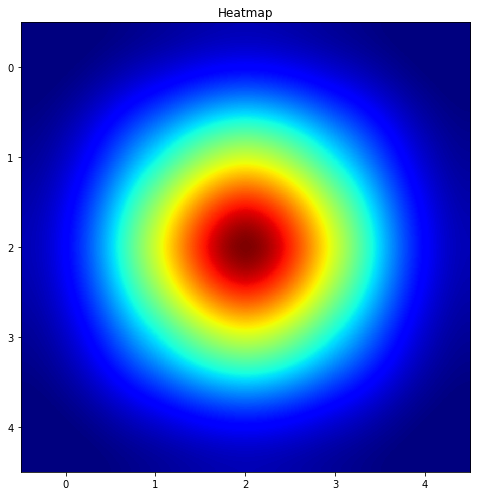

In [100]:
grid = gaussian_kernel() 

# plot with heatmap function 
heatmap(grid, cmap = 'jet', interpolation = 'spline16')

In [102]:
directions8

{'W': (-1, 0),
 'N': (0, 1),
 'E': (1, 0),
 'S': (0, -1),
 'NW': (-1, 1),
 'NE': (1, 1),
 'SE': (1, -1),
 'SW': (-1, -1)}

In [104]:
problem = PeakFindingProblem(initial, grid, directions8)

In [106]:
%timeit solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

681 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1.0

Hill climbing is about 24 times faster than simulated annealing. Simulated annealing makes up for this by its ability to be applicable in a larger number of scenarios. Here is an example: 

In [115]:
# define 2d Surface
grid = [[0, 0, 0, 1, 4], 
        [0, 0, 2, 8, 10], 
        [0, 0, 2, 4, 12], 
        [0, 2, 4, 8, 16], 
        [1, 4, 8, 16, 32]]

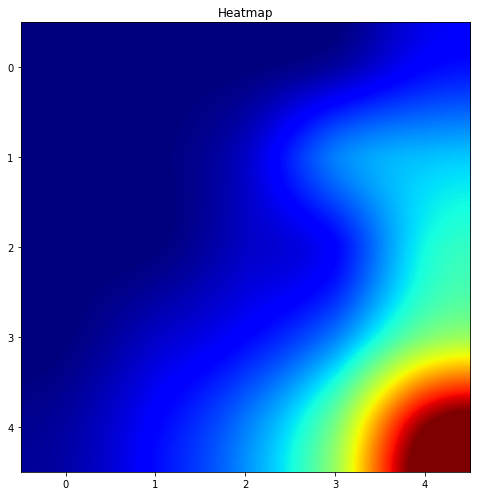

In [117]:
heatmap(grid, cmap = 'jet', interpolation = 'spline16')

In [127]:
# define problem
problem = PeakFindingProblem(initial, grid, directions8)

# solution by Hill Climbing
solution = problem.value(hill_climbing(problem))
print("Hill Climbing Solution: ", solution)

# solution by Simulated Annealing 
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
print("Simulated Annealing Solution: ", max(solutions))


Hill Climbing Solution:  0
Simulated Annealing Solution:  32


Even though both algorithms started from the same initial state, Hill climbing couldn't escape the planar region and gave a locally optimum solution of 0. Simulated Annealing was able to reach the peak at 32. A similar situation occurs when there are two peaks of different heights. 

### Genetic Algorithms 

Genetic algorithms are particularly useful in optimization and search problems with large state spaces. These algorithms make use of a population of solutions (also called states), where each solution/state represents a feasible solution. At each iteration (called a generation), the population gets updated using methods like crossover, mutation, and natural selection. 

Overview: 
1. Initialize random population
2. Calculate population fitness
3. Select individuals for mating 
4. Mate selected individuals to produce new population 
    There is a random chance to mutate individuals
5. Repeat from step 2 until an individual is fit enough or the maximum number of iterations is reached. 

Terminology: 
1. Individual / State: A list of elements (called genes) that represent possible solutions
2. Population: The list of all the individuals / states 
3. Gene pool: The alphabet of possible values for an individuals genes 
4. Generation / Iteration: The number of times the population will be updated 
5. Fitness: An individuals score, calculated by a function specific to the problem 

Crossover: 
a. Point Crossover: The crossover occurs around one (or more) point. The parents get split at the chosen point or points and then get merged. 
b. Uniform crossover: This type of crossover chooses the genes that get merged randomly

Mutation: 
When an offspring is produced, there is a chance it will mutate, having one or more of its genes mutated. 

Selection: 
At each iteration, the fittest indviduals are picked randomly to mate and produce offspring. We measure an individual fitness with a fitness function. 

The selection process is this: 
    1. Individuals are scored by the fitness function
    2. Individuals are picked randomly, according to their score. 


In [129]:
# Implementation
psource(genetic_algorithm)

The algorithm takes the following input: 
    1. population: The initial population
    2. fitness_fn: The problem's fitness function
    3. gene_pool: The gene pool of the states/individuals. By default 0 and 1
    4. f_thres: The fitness threshold. If an individual reaches that score, iteration stops. By default None, which means the algorithm will not halt until the generations are ran
    5. ngen: number of generations / iterations 
    6. pmut: probability of a mutation

The output is the state with the largest score. 

In [130]:
# pick at random a point and merge the parents around it
psource(recombine)

In [132]:
# pick a gene x to mutate and a gene from the gene pool to replace it with
psource(mutate)

In [134]:
# initialize population
# takes number of individuals in population, gene pool, and length of each state. 
# creates individuals with random genes and returns the population when done
psource(init_population)

In this problem, we will use a genetic algorithm to generate a particular target phrase from a population of random strings.

In [211]:
# define target string
target = 'Hello, Professor Braynova'

In [138]:
# generate gene pool

# the ASCII values of uppercase characters ranges from 65 to 91 
u_case = [chr(x) for x in range(65, 91)]

# the ASCII values of lowercase characters ranges from 97 to 123
l_case = [chr(x) for x in range(97, 123)]

gene_pool = []
# add uppercase
gene_pool.extend(u_case)
# add lowercase
gene_pool.extend(l_case)
# add space character
gene_pool.append(" ")

# set maximum size of each population
max_population = 100

# set mutation rate 
mutation_rate = 0.07 

In [212]:
# define fitness function
# this will return the number of matching characters beween the generated sample and the target phase 
def fitness_fn(sample): 
    # initialize fitness to 0
    fitness = 0
    for i in range(len(sample)): 
        # increment by 1 for each matching character 
        if sample[i] == target[i]:
            fitness += 1
    return fitness

In [213]:
# initialize a random population 
population = init_population(max_population, gene_pool, len(target))

# define how popn changes as number of generations increases.

# select two individuals with high fitness for offspring generation
parents = select(2, population, fitness_fn)

# create child. * unpacks the previous list variable
child = recombine(*parents)

# do this for every individual in the current population to generate a new popn
population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate) for i in range(len(population))]

# find individual with highest fitness
current_best = max(population, key = fitness_fn)

# convert best guess to strin and output
current_best_string = ''.join(current_best)
print(current_best_string)

ovTToZCnhytvAYKzleZbyfeTa


In [214]:
# define conditions to terminate the algorithm 

# number of generations
ngen = 3000

# set fitness threshold 
f_thres = len(target)

In [215]:
# generate ngen generations. 
# After each generation, calculate the fitness of the best individual of the generation
# and compare it to the value of f_thres
def genetic_algorithm_stepwise(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1200, pmut=0.1):
    for generation in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut) for i in range(len(population))]
        # stores the individual genome with the highest fitness in the current population
        current_best = ''.join(max(population, key=fitness_fn))
        print(f'Current best: {current_best}\t\tGeneration: {str(generation)}\t\tFitness: {fitness_fn(current_best)}\r', end='')
        
        # compare the fitness of the current best individual to f_thres
        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        
        # if fitness is greater than or equal to f_thres, we terminate the algorithm
        if fittest_individual:
            return fittest_individual, generation
    return max(population, key=fitness_fn) , generation

In [154]:
# essentiall the same as the one defined in search.py but with added functionality of printing out each generations data
psource(genetic_algorithm)

In [216]:
# create a new population and test the function we wrote 
population = init_population(max_population, gene_pool, len(target))
solution, generations = genetic_algorithm_stepwise(population, fitness_fn, gene_pool, f_thres, ngen, mutation_rate)

If we can create a fitness function to gauge how good or bad our approximate solutions are, there is a high chance we can get a satisfactory solution using a genetic algorithm.

### Graph Coloring 

Say we want to color a small graph with two colors in which no edge connects nodes of the same color. 

In [171]:
# define edges matrix
edges = {
    'A': [0, 1],
    'B': [0, 3],
    'C': [1, 2],
    'D': [2, 3]
}

In [173]:
# initialize population
population = init_population(8, ['R', 'G'], 4)
print(population)

[['R', 'G', 'G', 'G'], ['G', 'G', 'G', 'R'], ['G', 'G', 'G', 'G'], ['G', 'G', 'R', 'R'], ['R', 'G', 'R', 'G'], ['G', 'R', 'G', 'G'], ['G', 'G', 'R', 'G'], ['R', 'G', 'R', 'G']]


In [175]:
# define fitness function
def fitness(c): 
    return sum(c[n1] != c[n2] for (n1, n2) in edges.values())

In [177]:
# get solution 
solution = genetic_algorithm(population, fitness, gene_pool = ['R', 'G'])
print("Solution:", solution)

# print fitness score
print("Fitness Score:", fitness(solution))

Solution: ['G', 'R', 'G', 'R']
Fitness Score: 4


### Eight Queens 

In the eight queens problem, we are tasked with placing eight queens on an 8x8 chessboard without any queen threatening the others.

We can represent this problem in terms of a genetic algorithm. Given eight queens, suppose we have a gene for each of them. Then our gene pool consists of numbers from 0 to 7. The position of the gene will denote the row the queen is placed in. 

In [179]:
# initialize population
population = init_population(100, range(8), 8)
print(population[:5])

[[0, 4, 3, 3, 7, 7, 5, 6], [5, 1, 5, 5, 3, 2, 5, 0], [4, 5, 0, 4, 3, 6, 5, 6], [5, 7, 5, 7, 2, 3, 4, 3], [0, 7, 1, 7, 3, 5, 2, 4]]


In [184]:
# define fitness function
def fitness(q): 
    non_attacking = 0
    for row1 in range(len(q)):
        for row2 in range(row1 + 1, len(q)):
            col1 = int(q[row1])
            col2 = int(q[row2])
            row_diff = row1 - row2
            col_diff = col1 - col2
            # set constraint
            if col1 != col2 and row_diff != col_diff and row_diff != -col_diff:
                non_attacking += 1
    return non_attacking


In [187]:
# note that the best possible score is 28. For time reasons, we will set the threshold to 25
solution = genetic_algorithm(population, fitness, f_thres = 25, gene_pool = range(8))
print("Solution:", solution)
print("Fitness:", fitness(solution))

Solution: [3, 5, 7, 4, 2, 0, 5, 7]
Fitness: 25


### Generalized N-Queens

Here we are given a NxN chessboard with N queens. In the constraint satisfaction problems section, we see that this problem can be phrased as a CSP and solved using the min_conflicts algorithm in a way similar to hill climbing. 

Here we will solve it using heuristic search algorithms and classical search algorithms. 

In [189]:
psource(NQueensProblem)

In [191]:
# initialize problem
nqp = NQueensProblem(8)

4.83 ms ± 40.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


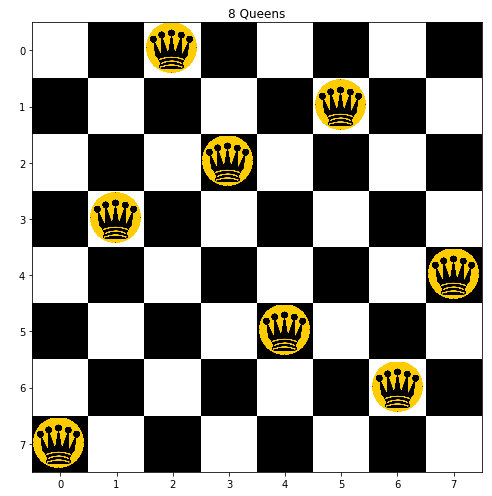

In [192]:
# solve using depth first tree search 
%timeit depth_first_tree_search(nqp)

dfts = depth_first_tree_search(nqp).solution()
plot_NQueens(dfts)

86.6 ms ± 839 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


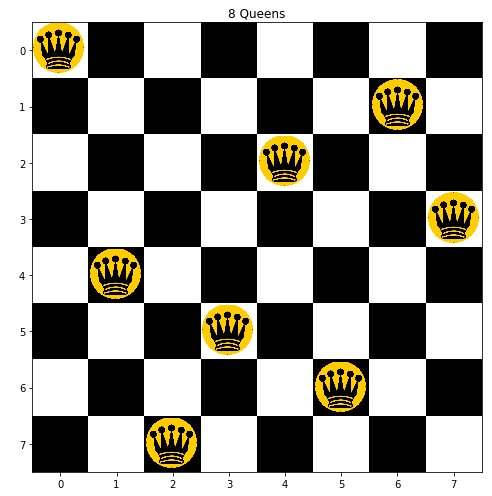

In [193]:
# breadth first tree search
%timeit breadth_first_tree_search(nqp)
bfts = breadth_first_tree_search(nqp).solution()
plot_NQueens(bfts)

431 ms ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


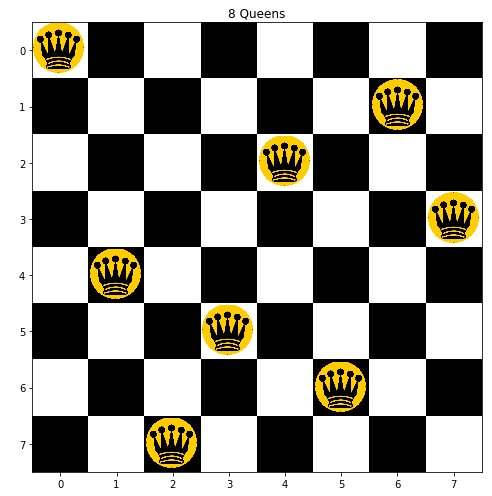

In [194]:
# uniform cost search
%timeit uniform_cost_search(nqp)
ucs = uniform_cost_search(nqp).solution()
plot_NQueens(ucs)

depth first tree search is about 20 times faster than breadth first tree search and more than 200 times faster than uniform cost search

In [196]:
# we can also solve this uing A* search with a heuristic 

# show heuristic
psource(NQueensProblem.h)

7.58 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


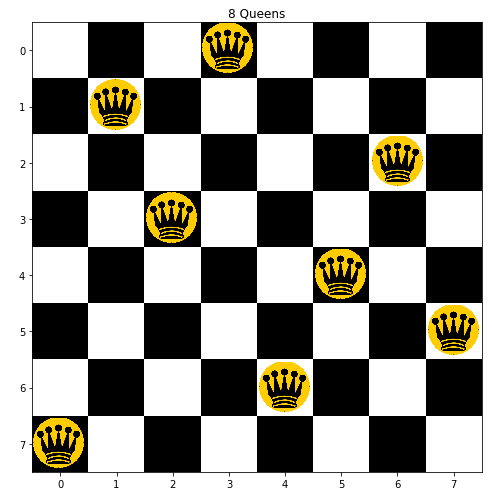

In [197]:
# astar with a heuristic is faster the BFTS and UCS
%timeit astar_search(nqp)
astar = astar_search(nqp).solution()
plot_NQueens(astar)

### AND-OR Graph Search 

An AND-OR graph is a graphical representation of the reduction of goals in conjunctions and disjunctions of subgoals. An AND-OR graph can be seen as a generalization of a directed graph. It contains a number of vertices and generalized edges that connect the vertices. 

AND-OR graphs can be searched in depth first, breadth first, and best first ways searching the state space linearly or in parallel. 

This implementation of AND-OR search searches over graphs generated by non-deterministic environments and returns a conditional plan that reaches a goal state in all circumstances. 


In [198]:
psource(and_or_graph_search)

In [200]:
# application of and_or_graph_search to the simple vacuum world example
vacuum_world = GraphProblemStochastic('State_1', ['State_7', 'State_8'], vacuum_world)
plan = and_or_graph_search(vacuum_world)
plan

['Suck',
 {'State_7': [], 'State_5': ['Right', {'State_6': ['Suck', {'State_8': []}]}]}]

In [203]:
def run_plan(state, problem, plan): 
    if problem.goal_test(state):
        return True
    if len(plan) is not 2:
        return False
    predicate = lambda x: run_plan(x, problem, plan[1][x])
    return all(predicate(r) for r in problem.result(state, plan[0]))

run_plan('State_1', vacuum_world, plan)

True

### Online DFS Agent

Offline search algorithms are a class of algorithms that compute a complete solution before executing it. In contrast, an online search agent interleaves computation and action. Online search is better for most dynamic environments and necessary for unknown environments. 

For a fully observable environment, an online agent cycles through 3 steps: 
1. Taking an action, 2. Computing the step cost, 3. Checking if the goal has been reached 

In [204]:
psource(OnlineDFSAgent)

### LRTA* Agent

Hill climbing has issues with getting stuck in local minima / maxima. A way around this is to restart it a few times and return the result with the lowest total cost.

A better improvement would be to give the hill climbing algorithm a memory element. We store the current best heuristic estimate and it is updted as the agent gains experience in the state space. The estimated optimal cost is made more accurate as time passes and each time the local minima is flattened out until we escape it. 

This learning scheme is called learning real-time A* or LRTA*. 

In [205]:
psource(LRTAStarAgent)

In [206]:
# define environment
one_dim_state_space

In [207]:
# define an instance of OnlineSearchProblem
LRTA_problem = OnlineSearchProblem('State_3', 'State_5', one_dim_state_space)

In [208]:
# initialize LRTAStarAgent for the problem 
lrta_agent  = LRTAStarAgent(LRTA_problem)

# pass percepts to the agent 
lrta_agent('State_3')
lrta_agent('State_4')
lrta_agent('State_5')


State_3 Right State_4
State_3 Left State_2
State_3 Right State_4
State_3 Left State_2
State_4 Right State_5
State_4 Left State_3
